# Grid World迷宮之值循環(Value Iteration)

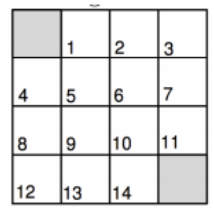

In [1]:
# 從IPython.display模組匯入Image類別，用來在Jupyter Notebook中顯示圖片
from IPython.display import Image

# 載入並顯示位於當前目錄中的grid_world.png圖片
Image('./grid_world.png')

In [2]:
# 匯入zipfile模組，用來處理.zip壓縮檔案
import zipfile

# 使用with敘述開啟lib.zip壓縮檔案，確保使用完自動關閉
with zipfile.ZipFile("lib.zip") as zf:
    # 使用infolist()取得壓縮檔中所有檔案的資訊(ZipInfo物件)
    for info in zf.infolist():
    
        # 因為某些zip壓縮檔的檔名是以cp437編碼(特別是從Windows系統壓縮的)
        # 所以這裡先將原本的檔名(字串)用cp437編碼為bytes，再用utf-8解碼為正確的字串
        # 這樣可以正確顯示中文或特殊字元的檔名
        print(info.filename.encode('cp437').decode('utf-8'))

        # 將目前這個檔案(info)解壓縮到target_folder資料夾中
        zf.extract(info, "target_folder")

lib/__init__.py
lib/__pycache__/
lib/__pycache__/__init__.cpython-38.pyc
lib/__pycache__/__init__.cpython-39.pyc
lib/__pycache__/plotting.cpython-38.pyc
lib/__pycache__/plotting.cpython-39.pyc
lib/atari/
lib/atari/__init__.py
lib/atari/helpers.py
lib/atari/state_processor.py
lib/envs/
lib/envs/.ipynb_checkpoints/
lib/envs/.ipynb_checkpoints/gridworld-checkpoint.py
lib/envs/__init__.py
lib/envs/__pycache__/
lib/envs/__pycache__/__init__.cpython-36.pyc
lib/envs/__pycache__/__init__.cpython-38.pyc
lib/envs/__pycache__/__init__.cpython-39.pyc
lib/envs/__pycache__/blackjack.cpython-38.pyc
lib/envs/__pycache__/blackjack.cpython-39.pyc
lib/envs/__pycache__/cliff_walking.cpython-36.pyc
lib/envs/__pycache__/cliff_walking.cpython-38.pyc
lib/envs/__pycache__/cliff_walking.cpython-39.pyc
lib/envs/__pycache__/discrete.cpython-38.pyc
lib/envs/__pycache__/discrete.cpython-39.pyc
lib/envs/__pycache__/gridworld.cpython-38.pyc
lib/envs/__pycache__/gridworld.cpython-39.pyc
lib/envs/__pycache__/gridworld0

In [3]:
# 匯入sys模組，用於與系統互動
import sys

# 顯示目前使用的Python版本資訊
sys.version

'3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]'

In [4]:
# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 從lib.envs.gridworld模組中匯入自訂的GridworldEnv類別
# 這代表有一個自定義的「網格世界」強化學習環境，位於專案的lib/envs/gridworld.py檔案中
from lib.envs.gridworld import GridworldEnv

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [5]:
# 修正np.bool已被移除的問題(NumPy1.20+不再支援np.bool)
# 如果當前NumPy沒有np.bool屬性(新版會移除)
if not hasattr(np, 'bool'):
    # 則將np.bool指定為內建的bool，等效於舊版的np.bool行為
    np.bool = bool  # 等價替代，讓使用np.bool的舊程式碼能正常執行

C:\Users\hankc\AppData\Local\Temp\ipykernel_10020\585787934.py:3: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


In [6]:
# 建立一個GridWorld強化學習環境實例
env = GridworldEnv()

# 動作對應的數值編碼(Action Encoding)：
# 在強化學習環境中，每個數字代表智能體(Agent)的一個移動方向

# UP = 0     # 向上移動，代表智能體往上方的格子前進
# RIGHT = 1  # 向右移動，代表智能體往右方的格子前進
# DOWN = 2   # 向下移動，代表智能體往下方的格子前進
# LEFT = 3   # 向左移動，代表智能體往左方的格子前進

c:\Users\hankc\anaconda3\Lib\site-packages\gym\utils\seeding.py:41: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


In [7]:
# 值迭代函數：使用值迭代方法來計算最優策略與狀態值函數
def value_iteration(env, theta = 0.0001, discount_factor = 1.0):
    times = 0  # 用來計算進行了多少次迭代

    # 計算行動值函數(一步前瞻)：計算給定狀態下每個動作的行動值
    def one_step_lookahead(state, V):
        A = np.zeros(env.nA)  # 初始化動作價值為0
        for a in range(env.nA):
            # 根據環境模型，計算該動作的期望回報
            for prob, next_state, reward, done in env.P[state][a]:
                # 行動值Q(s, a) = Σ [P(s'|s, a) * (r + γ * V(s'))]
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A

    # 狀態值函數初始化：將每個狀態的價值初始化為0
    V = np.zeros(env.nS)

    # 開始迭代，直到所有狀態的價值收斂
    while True:
        times += 1
        # 用來存儲最大變動量
        delta = 0

        # 更新每個狀態的價值
        for s in range(env.nS):
            # 計算該狀態下的行動值函數
            A = one_step_lookahead(s, V)

            # 取得最佳行動的價值
            best_action_value = np.max(A)

            # 計算此狀態的價值變動量
            delta = max(delta, np.abs(best_action_value - V[s]))
            print('delta', delta)

            # 更新狀態值函數
            V[s] = best_action_value

        # 若最大變動量小於設定的收斂門檻，則停止迭代
        if delta < theta:
            print('最後訓練幾次', times)
            break

    # 初始化隨機策略，並將每個狀態的最佳行動設置為選擇行動
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # 計算該狀態下每個動作的行動值
        A = one_step_lookahead(s, V)

        # 選擇行動值最大的動作(即最佳行動)
        best_action = np.argmax(A)

        # 將最佳行動的機率設為1.0(選擇最佳行動)
        policy[s, best_action] = 1.0

    # 傳回最優策略與最終的狀態值函數
    return policy, V

In [8]:
# 執行值迭代(Value Iteration)，並傳回最優策略和最終的狀態值函數
policy, v = value_iteration(env)

delta 0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 0
delta 0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 0
delta 0
delta 0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
delta 0
最後訓練幾次 4


In [9]:
# 顯示最終策略的機率分配(每個狀態對每個動作的選擇機率)
print("策略機率分配:")
print(policy)
print("\n")

# 顯示每個狀態下選擇機率最高的動作(即最優策略)
# 將一維動作索引轉成4x4矩陣的形式(對應FrozenLake的地圖)
# 動作代號：0 = ↑, 1 = →, 2 = ↓, 3 = ←
print("4x4 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):")
print(np.reshape(np.argmax(policy, axis = 1), env.shape))
print("\n")

# 顯示最終的狀態值函數(每個狀態的預期累積報酬)
# 將一維的狀態值向量v轉成4x4矩陣的形式以對應地圖視覺結構
print("4x4 狀態值函數:")
print(v.reshape(env.shape))

策略機率分配:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


4x4 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]


4x4 狀態值函數:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


In [10]:
# 驗證計算出的狀態值函數v是否與預期結果expected_v接近(小數點後2位)
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal = 2)

## CliffWalkingEnv

In [11]:
# 從自訂模組載入懸崖漫步環境
from lib.envs.cliff_walking import CliffWalkingEnv

# 初始化環境：這裡使用的是CliffWalking(懸崖走路)環境
# 起點在左下角，終點在右下角，中間的懸崖會導致掉落並受到負獎勵
env = CliffWalkingEnv()

# 執行值迴圈，設定較大的誤差容忍度theta以加速收斂
policy, v = value_iteration(env, theta = 2)

delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 2.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
delta 1.0
最後訓練幾次 2


In [12]:
# 顯示最終策略的機率分配(每個狀態對每個動作的選擇機率)
print("策略機率分配:")
print(policy)
print("")

# 顯示每個狀態下選擇機率最高的動作(即最優策略)
# 將一維動作索引轉成4x12矩陣的形式
# 動作代號：0 = ↑, 1 = →, 2 = ↓, 3 = ←
print("4x12 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):")
print(np.reshape(np.argmax(policy, axis = 1), env.shape))
print("")

# 顯示最終的狀態值函數(每個狀態的預期累積回報)
# 將一維的狀態值向量v轉成4x12矩陣的形式
print("4x12 狀態值函數:")
print(v.reshape(env.shape))

策略機率分配:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]

4x12 策略機率分配(0 = up, 1 = right, 2 = down, 3 = left):
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]

4x12 狀態值函數:
[[-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.]
 [-2. -2. -2. -2. -2. -2. -2. -2. -2. -2. -2.